In [1]:
!pip install keras-layer-normalization

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras_layer_normalization import LayerNormalization
# from keras.layers.normalization import BatchNormalization
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns

In [3]:
#Keras library for CIFAR dataset
from keras.datasets import cifar10
(x_train, y_train),(x_test, y_test)=cifar10.load_data()

#Train-validation-test split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

#Dimension of the CIFAR10 dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [4]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(10))
AlexNet.add(LayerNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 layer_normalization (Layer  (None, 8, 8, 96)          192       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 96)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 layer_normalization_1 (Lay  (None, 4, 4, 256)         5

In [5]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'SGD', metrics=['accuracy'])

In [6]:
#Onehot Encoding the labels.
from sklearn.utils.multiclass import unique_labels
from keras.utils import to_categorical

#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


In [7]:
#Image Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [8]:
#Learning Rate Annealer
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_accuracy',  factor=.01,  patience=3,  min_lr=1e-5)
#To train the model, we will define below the number of epochs, the number of batches and the learning rate.

#Defining the parameters
batch_size = 50
epochs = 50
learn_rate = 0.01

In [9]:
#Training the model
AlexNet.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_val, y_val, batch_size=batch_size), validation_steps = 250, callbacks = [lrr], verbose=1)

Epoch 1/50
700/700 [==============================] - 52s 51ms/step - loss: 2.2201 - accuracy: 0.1755 - val_loss: 1.9107 - val_accuracy: 0.2991 - lr: 0.0100
Epoch 2/50
700/700 [==============================] - 36s 52ms/step - loss: 1.8716 - accuracy: 0.3105 - val_loss: 1.7174 - val_accuracy: 0.3729 - lr: 0.0100
Epoch 3/50
700/700 [==============================] - 36s 51ms/step - loss: 1.7211 - accuracy: 0.3722 - val_loss: 1.6276 - val_accuracy: 0.4240 - lr: 0.0100
Epoch 4/50
700/700 [==============================] - 35s 50ms/step - loss: 1.6097 - accuracy: 0.4263 - val_loss: 1.5412 - val_accuracy: 0.4574 - lr: 0.0100
Epoch 5/50
700/700 [==============================] - 32s 45ms/step - loss: 1.5265 - accuracy: 0.4608 - val_loss: 1.4935 - val_accuracy: 0.4777 - lr: 0.0100
Epoch 6/50
700/700 [==============================] - 30s 43ms/step - loss: 1.4624 - accuracy: 0.4846 - val_loss: 1.3692 - val_accuracy: 0.5145 - lr: 0.0100
Epoch 7/50
700/700 [==============================] - 36s 

In [10]:
history

!pip install keras-layer-normalization
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras_layer_normalization import LayerNormalization
# from keras.layers.normalization import BatchNormalization
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
#Keras library for CIFAR dataset
from keras.datasets import cifar10
(x_train, y_train),(x_test, y_test)=cifar10.load_data()

#Train-validation-test split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

#Dimension of the CIFAR10 dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(LayerNo

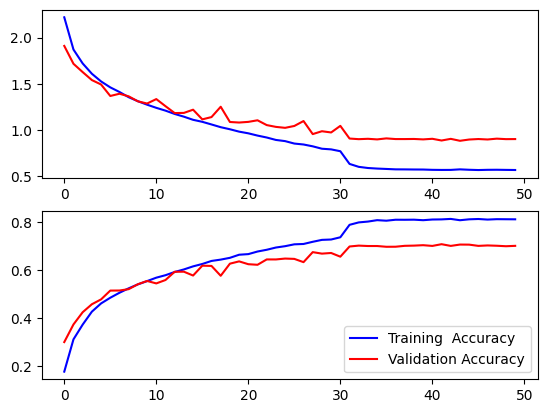

In [11]:
import matplotlib.pyplot as plt
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(AlexNet.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(AlexNet.history.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(AlexNet.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(AlexNet.history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

In [12]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

313/313 [==============================] - 2s 5ms/step
Confusion matrix, without normalization


<Axes: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

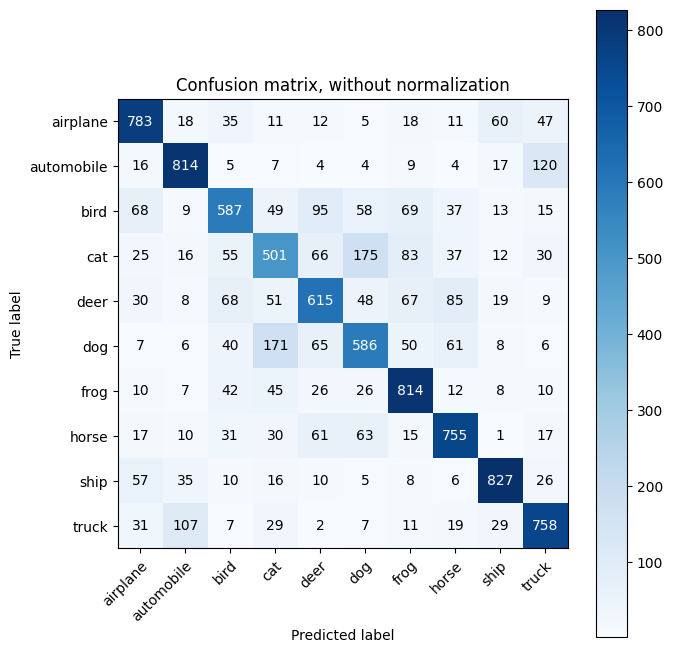

In [24]:
#Making prediction
y_pred=AlexNet.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)

y_true=np.argmax(y_test,axis=1)
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(y_true,y_pred)



# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')

Normalized confusion matrix


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

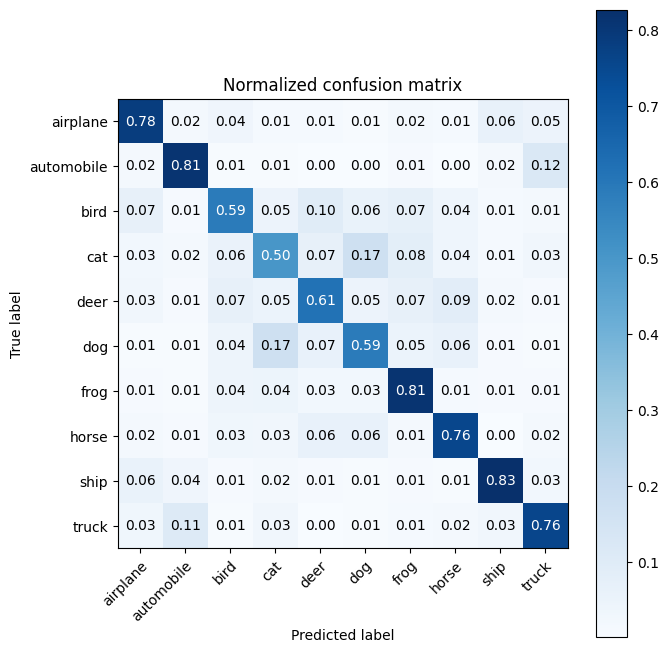

In [26]:
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')